# BERT Predict classification

## 1. Setup the environment

### 1.1 Setup colab environment

#### 1.1.1 Install packages

In [ ]:
!pip install transformers==4.10.3
!pip install sentencepiece

#### 1.1.2 Use more RAM

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

#### 1.1.3 Mount GoogleDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 1.2 Setup GPU

In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# for MacOS
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print('We will use the GPU')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')



We will use the GPU


### 1.3 Import librairies

In [8]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

from transformers import BertTokenizer, BertForSequenceClassification, CamembertTokenizer, TextClassificationPipeline
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

import pickle 

## 2. Load Data

In [ ]:
#!wget https://geode.liris.cnrs.fr/files/datasets/EDdA/Classification/LGE_withContent.tsv
#!wget https://geode.liris.cnrs.fr/EDdA-Classification/datasets/EDdA_dataset_articles_no_superdomain.tsv
#!wget https://geode.liris.cnrs.fr/EDdA-Classification/datasets/Parallel_datatset_articles_230215.tsv

In [9]:
#drive_path = "drive/MyDrive/Classification-EDdA/"
drive_path = "../"
#path = "/Users/lmoncla/git/gitlab.liris/GEODE/EDdA/output/"
path = "/Users/lmoncla/Nextcloud-LIRIS/GEODE/GEODE - Partage consortium/Corpus/EDdA/"
#path = "/Users/lmoncla/Nextcloud-LIRIS/GEODE/GEODE - Partage consortium/Corpus/LGE/"

#filepath = "Parallel_datatset_articles_230215.tsv"
#filepath = "EDdA_dataset_articles_221208.tsv"
filepath = "EDdA_dataset_articles_superdomainBERT_230327.tsv"
#filepath = 'LGE_dataset_articles_230314.tsv'
#filepath = "EDdA_dataset_paragraphs.tsv"

#corpus = 'lge'
corpus = 'edda'
#corpus = ''

In [10]:
df = pd.read_csv(path + filepath, sep="\t")
df.head()

volume  numero                                head                author  \
0       1       1                          Title Page              unsigned   
1       1       2   A MONSEIGNEUR LE COMTE D'ARGENSON  Diderot & d'Alembert   
2       1       3  DISCOURS PRÉLIMINAIRE DES EDITEURS            d'Alembert   
3       1       5                            A, a & a            Dumarsais5   
4       1       6                                   A            Dumarsais5   

     edda_class enccre_id enccre_class  \
0  unclassified       NaN          NaN   
1  unclassified       NaN          NaN   
2  unclassified       NaN          NaN   
3     Grammaire    v1-1-0    Grammaire   
4  unclassified    v1-1-1    Grammaire   

                                             content  \
0  \n\nENCYCLOPÉDIE,\nDICTIONNAIRE RAISONNÉ\nDES ...   
1  \n\nA MONSEIGNEUR\nLE COMTE D'ARGENSON,\nMINIS...   
2  \n\nDISCOURS PRÉLIMINAIRE\nDES EDITEURS.\n\n\n...   
3  \nA, a & a s.m. (ordre Encyclopéd.\nEntend. Sc...   
4  \nA, mot, est 1. la troisieme personne du prés...   

                           content_without_designant  \
0  \n\nENCYCLOPÉDIE,\nDICTIONNAIRE RAISONNÉ\nDES ...   
1  \n\nA MONSEIGNEUR\nLE COMTE D'ARGENSON,\nMINIS...   
2  \n\nDISCOURS PRÉLIMINAIRE\nDES EDITEURS.\n\n\n...   
3  \nA, a & a s.m. (ordre Encyclopéd.\nEntend. Sc...   
4  \nA, mot, est 1. la troisieme personne du prés...   

                                     first_paragraph  nb_words  super_domain  \
0  \n\nENCYCLOPÉDIE,\nDICTIONNAIRE RAISONNÉ\nDES ...       151  unclassified   
1  \n\nA MONSEIGNEUR\nLE COMTE D'ARGENSON,\nMINIS...       208  unclassified   
2       \n\nDISCOURS PRÉLIMINAIRE\nDES EDITEURS.\n\n     44669  unclassified   
3  \nA, a & a s.m. (ordre Encyclopéd.\nEntend. Sc...       711   Philosophie   
4  \nA, mot, est 1. la troisieme personne du prés...       238  unclassified   

  lge-superdomainPred1  lge-superdomainProba1 lge-superdomainPred2  \
0          Philosophie               0.986489       Belles-lettres   
1          Philosophie               0.943809             Histoire   
2       Belles-lettres               0.926219             Histoire   
3          Philosophie               0.978732            Politique   
4          Philosophie               0.988337       Belles-lettres   

   lge-superdomainProba2 lge-superdomainPred3  lge-superdomainProba3  
0               0.002821            Politique               0.001780  
1               0.014932            Politique               0.014871  
2               0.019612           Beaux-arts               0.011769  
3               0.004091       Belles-lettres               0.002425  
4               0.003174           Beaux-arts               0.001221

In [6]:
#df = df[df["head"]=="WOLSTROPE"]
#df

volume  numero       head    author          edda_class   enccre_id  \
257914      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257915      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257916      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257917      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257918      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
...        ...     ...        ...       ...                 ...         ...   
257970      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257971      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257972      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257973      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257974      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   

       enccre_class  paragraph_id  \
257914   Géographie             1   
257915   Géographie             2   
257916   Géographie             3   
257917   Géographie             4   
257918   Géographie             5   
...             ...           ...   
257970   Géographie            57   
257971   Géographie            58   
257972   Géographie            59   
257973   Géographie            60   
257974   Géographie            61   

                                                  content  
257914  \nWOLSTROPE, (Géog. mod.) bourg d'Angleterre,\...  
257915  \nC'est dans cet homme merveilleux, que l'Angl...  
257916  \nIl leva le voile qui cachoit les plus grands...  
257917  \nIl fut reçu en 1660 dans l'université de Cam...  
257918  \nEn 1655, Wallis publia son arithemica infini...  
...                                                   ...  
257970  \nAprès la mort de M. Newton on trouva dans se...  
257971  \nEn 1733, on imprima dans la même ville in-4°...  
257972  \nEn 1736, M. Colson mit au jour à Londres in-...  
257973  \nM. Birch ayant fait imprimer à Londres en 17...  
257974  \nEnfin ceux qui voudront ne rien négliger sur...  

[61 rows x 9 columns]

In [11]:
#dataset = df['content'].values
#dataset = df[corpus+'-content'].values

dataset = df['content'].values

## 3. Load model and predict

### 3.1 BERT / CamemBERT

In [16]:
model_name = "bert-base-multilingual-cased"
#model_name = "camembert-base"
#model_path = path + "models/model_" + model_name + "_s10000.pt"

#model_path = drive_path + "models/model_" + model_name + "_s10000_superdomains.pt"
model_path = drive_path + "models/model_lge-bio_" + model_name + ".pt"

In [13]:
def generate_dataloader(tokenizer, sentences, batch_size = 8, max_len = 512):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids_test = []
    # For every sentence...
    for sent in sentences:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            # This function also supports truncation and conversion
                            # to pytorch tensors, but I need to do padding, so I
                            # can't use these features.
                            #max_length = max_len,          # Truncate all sentences.
                            #return_tensors = 'pt',     # Return pytorch tensors.
                    )
        input_ids_test.append(encoded_sent)

    # Pad our input tokens
    padded_test = []
    for i in input_ids_test:
        if len(i) > max_len:
            padded_test.extend([i[:max_len]])
        else:
            padded_test.extend([i + [0] * (max_len - len(i))])
    input_ids_test = np.array(padded_test)

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids_test:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert to tensors.
    inputs = torch.tensor(input_ids_test)
    masks = torch.tensor(attention_masks)
    #set batch size

    # Create the DataLoader.
    data = TensorDataset(inputs, masks)
    prediction_sampler = SequentialSampler(data)

    return DataLoader(data, sampler=prediction_sampler, batch_size=batch_size)



def predict(model, dataloader, device):

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions_test , true_labels = [], []
    pred_labels_ = []
    # Predict
    for batch in dataloader:
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from the dataloader
        b_input_ids, b_input_mask = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        #print(logits)

        # Move logits and labels to CPU ???
        logits = logits.detach().cpu().numpy()
        #print(logits)

        # Store predictions and true labels
        predictions_test.append(logits)

        pred_labels = []
        
        for i in range(len(predictions_test)):
            # The predictions for this batch are a 2-column ndarray (one column for "0"
            # and one column for "1"). Pick the label with the highest value and turn this
            # in to a list of 0s and 1s.
            pred_labels_i = np.argmax(predictions_test[i], axis=1).flatten()
            pred_labels.append(pred_labels_i)

    pred_labels_ += [item for sublist in pred_labels for item in sublist]
    return pred_labels_



#https://discuss.huggingface.co/t/i-have-trained-my-classifier-now-how-do-i-do-predictions/3625/3


In [14]:
if model_name == 'bert-base-multilingual-cased' :
    print('Loading Bert Tokenizer...')
    tokenizer = BertTokenizer.from_pretrained(model_name)
elif model_name == 'camembert-base':
    print('Loading Camembert Tokenizer...')
    tokenizer = CamembertTokenizer.from_pretrained(model_name)

Loading Bert Tokenizer...



https://discuss.huggingface.co/t/an-efficient-way-of-loading-a-model-that-was-saved-with-torch-save/9814

https://github.com/huggingface/transformers/issues/2094


In [17]:
model = BertForSequenceClassification.from_pretrained(model_path).to(device.type)

In [12]:
#data_loader = generate_dataloader(tokenizer, data)

In [13]:
#pred = predict(model, data_loader, device)

In [18]:
# https://huggingface.co/docs/transformers/main_classes/pipelines

def data(): #TODO : 
    for d in dataset:
        yield f"{d}"

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=device)

# https://stackoverflow.com/questions/67849833/how-to-truncate-input-in-the-huggingface-pipeline
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}

/opt/homebrew/Caskroom/miniforge/base/envs/geode-classification-py39/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [20]:
pred = []

for out in tqdm(pipe(data(), **tokenizer_kwargs)):
    out = sorted(out, key=lambda d: d['score'], reverse=True) 
    #print(int(out[0]['label'][6:]), out[0]['score'], int(out[1]['label'][6:]), out[1]['score'], int(out[2]['label'][6:]), out[2]['score']) # label ### TODO modifier ici
    pred.append([int(out[0]['label'][6:]), out[0]['score'], int(out[1]['label'][6:])])

pred = np.array(pred)

631it [01:42,  4.27it/s]

In [16]:
# Load label encoder

#encoder_filename = "models/label_encoder.pkl"
#encoder_filename = "models/label_encoder_superdomains.pkl"
encoder_filename = "models/lge-bio_label_encoder.pkl"

with open(drive_path + encoder_filename, 'rb') as file:
      encoder = pickle.load(file)

/opt/homebrew/Caskroom/miniforge/base/envs/geode-classification-py39/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
pred1 = list(encoder.inverse_transform(pred[:,0].astype(int)))
pred2 = list(encoder.inverse_transform(pred[:,2].astype(int)))
#pred3 = list(encoder.inverse_transform(pred[:,4].astype(int)))


In [19]:
'''
df[corpus+'-superdomainPred1'] = pred1
df[corpus+'-superdomainProba1'] = pred[:,1]
df[corpus+'-superdomainPred2'] = pred2
df[corpus+'-superdomainProba2'] = pred[:,3]
df[corpus+'-superdomainPred3'] = pred3
df[corpus+'-superdomainProba3'] = pred[:,5]
'''

df[corpus+'-bioPred'] = pred1
df[corpus+'-bioProba'] = pred[:,1]

In [20]:
df.head(10)

volume  numero       head    author          edda_class   enccre_id  \
257914      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257915      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257916      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257917      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257918      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257919      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257920      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257921      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257922      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
257923      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   

       enccre_class  paragraph_id  \
257914   Géographie             1   
257915   Géographie             2   
257916   Géographie             3   
257917   Géographie             4   
257918   Géographie             5   
257919   Géographie             6   
257920   Géographie             7   
257921   Géographie             8   
257922   Géographie             9   
257923   Géographie            10   

                                                  content  \
257914  \nWOLSTROPE, (Géog. mod.) bourg d'Angleterre,\...   
257915  \nC'est dans cet homme merveilleux, que l'Angl...   
257916  \nIl leva le voile qui cachoit les plus grands...   
257917  \nIl fut reçu en 1660 dans l'université de Cam...   
257918  \nEn 1655, Wallis publia son arithemica infini...   
257919  \nDans le même tems, & par la'même méthode,\ni...   
257920  \nDurant l'été de l'année 1665, la peste l'aya...   
257921  \nSi l'abscisse d'une figure courbe quelconque...   
257922  \nAu commencement de l'année 1665, il trouva u...   
257923  \nAu printems de cette même année, il trouva l...   

       edda-superdomainPred1  edda-superdomainProba1 edda-superdomainPred2  \
257914            Géographie                0.998645              Histoire   
257915              Histoire                0.969261           Philosophie   
257916              Histoire                0.943197        Belles-lettres   
257917              Physique                0.293445              Histoire   
257918              Physique                0.985414               Métiers   
257919              Physique                0.984760               Métiers   
257920              Physique                0.837905              Médecine   
257921              Physique                0.985408               Métiers   
257922              Physique                0.984727               Métiers   
257923              Physique                0.984294               Métiers   

        edda-superdomainProba2 edda-superdomainPred3  edda-superdomainProba3  
257914                0.000147             Militaire                0.000114  
257915                0.008024        Belles-lettres                0.005748  
257916                0.016374              Religion                0.010389  
257917                0.251549        Belles-lettres                0.232839  
257918                0.003760              Médecine                0.002926  
257919                0.003602              Médecine                0.002931  
257920                0.108600        Belles-lettres                0.008510  
257921                0.003823              Médecine                0.002478  
257922                0.004349              Médecine                0.003002  
257923                0.005065              Médecine                0.002500

In [21]:
#df.to_csv(drive_path + "predictions/EDdA_dataset_articles_superdomainBERT_230327.tsv", sep="\t", index=False)
df.to_csv(drive_path + "predictions/EDdA_dataset_articles_superdomain+bio_230327.tsv", sep="\t", index=False)
#df.to_csv(drive_path + "predictions/LGE_dataset_articles_superdomainBERT_230321.tsv", sep="\t", index=False)
#df.to_csv(drive_path + "predictions/Wolstrope_paragraphs_230327.tsv", sep="\t", index=False)

In [ ]:
df.loc[(df[corpus+'-superdomainProba1'] == 'Géographie')]

In [ ]:
df.shape

# Test pour l'article Wolstrope

In [5]:
drive_path = '../'
df = pd.read_csv(drive_path + "predictions/Wolstrope_paragraphs_230327.tsv", sep="\t")
df.head()

volume  numero       head    author          edda_class   enccre_id  \
0      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
1      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
2      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
3      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   
4      17    2381  WOLSTROPE  Jaucourt  Géographie moderne  v17-1454-0   

  enccre_class  paragraph_id  \
0   Géographie             1   
1   Géographie             2   
2   Géographie             3   
3   Géographie             4   
4   Géographie             5   

                                             content edda-superdomainPred1  \
0  \nWOLSTROPE, (Géog. mod.) bourg d'Angleterre,\...            Géographie   
1  \nC'est dans cet homme merveilleux, que l'Angl...              Histoire   
2  \nIl leva le voile qui cachoit les plus grands...              Histoire   
3  \nIl fut reçu en 1660 dans l'université de Cam...              Physique   
4  \nEn 1655, Wallis publia son arithemica infini...              Physique   

   edda-superdomainProba1 edda-superdomainPred2  edda-superdomainProba2  \
0                0.998645              Histoire                0.000147   
1                0.969261           Philosophie                0.008024   
2                0.943197        Belles-lettres                0.016374   
3                0.293445              Histoire                0.251549   
4                0.985414               Métiers                0.003760   

  edda-superdomainPred3  edda-superdomainProba3  
0             Militaire                0.000114  
1        Belles-lettres                0.005748  
2              Religion                0.010389  
3        Belles-lettres                0.232839  
4              Médecine                0.002926

<AxesSubplot: >

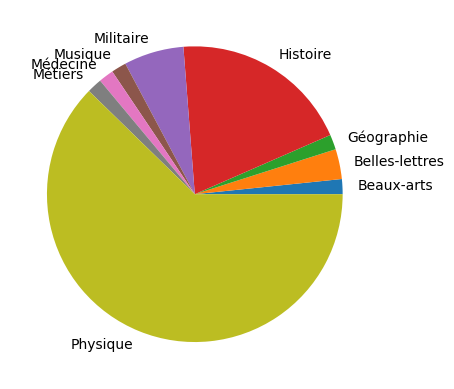

In [6]:
df.groupby(['edda-superdomainPred1']).size().plot.pie()